In [1]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
#!/usr/bin/python
import csv
import time
import json
import talib
import requests
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, date, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [3]:
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.bitbank.cc'
pair = 'btc_jpy'
period = '1min'

today = datetime.today()
yesterday = today - timedelta(days=1)
today = "{0:%Y%m%d}".format(today)
yesterday = "{0:%Y%m%d}".format(yesterday)

In [4]:
def api_ohlcv(timestamp):
    api_url = '{0}/{1}/candlestick/{2}/{3}'.format(api_url_base, pair, period, timestamp)
    response = requests.get(api_url, headers=headers)

    if response.status_code == 200:
        ohlcv = json.loads(response.content.decode('utf-8'))['data']['candlestick'][0]['ohlcv']
        return ohlcv
    else:
        return None

In [5]:
ohlcv = api_ohlcv('20191017')
open, high, low, close, volume, timestamp = [],[],[],[],[],[]
for i in ohlcv:
    open.append(int(i[0]))
    high.append(int(i[1]))
    low.append(int(i[2]))
    close.append(int(i[3]))
    volume.append(float(i[4]))
    time_str = str(i[5])
    timestamp.append(datetime.fromtimestamp(int(time_str[:10])).strftime('%Y/%m/%d %H:%M:%M'))

date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
df = pd.DataFrame({'open': open, 'high': high, 'low': low, 'close': close, 'volume': volume}, index=date_time_index)
# df.index += pd.offsets.Hour(9) # adjustment for JST
print(df.shape)
print(df.columns)

(1440, 5)
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


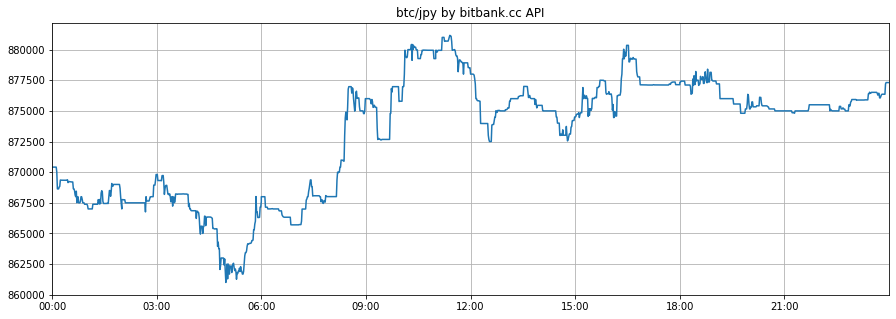

In [6]:
def draw(df):
    df1 = df.copy()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('btc/jpy by bitbank.cc API')
    ax.plot(df1.index, df1.close,label="original")
    ax.set_xlim(df1.index[0], df1.index[-1])
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax.grid()
    
draw(df)

In [14]:
# pct_change
f = lambda x: 1 if x>0.0001 else -1 if x<-0.0001 else 0 if -0.0001<=x<=0.0001 else np.nan
y = df.rename(columns={'close': 'y'}).loc[:, 'y'].pct_change(1).shift(-1).fillna(0)
X = df.copy()
y_ = pd.DataFrame(y.map(f), columns=['y'])
y = df.rename(columns={'close': 'y'}).loc[:, 'y'].pct_change(1).fillna(0)
df_ = pd.concat([X, y_], axis=1)
input_arrays = { 'open': df['open'].values, 'high': df['high'].values, 'low': df['low'].values, 'close': df['close'].values, 'volume': df['volume'].values }

# check the shape
print('----------------------------------------------------------------------------------------')
print('X shape: (%i,%i)' % X.shape)
print('y shape: (%i,%i)' % y_.shape)
print('----------------------------------------------------------------------------------------')
print(y_.groupby('y').size())
print('y=1 up, y=0 stay, y=-1 down')
print('----------------------------------------------------------------------------------------')
pd.set_option('display.max_rows', 200)

----------------------------------------------------------------------------------------
X shape: (1440,5)
y shape: (1440,1)
----------------------------------------------------------------------------------------
y
-1     194
 0    1042
 1     204
dtype: int64
y=1 up, y=0 stay, y=-1 down
----------------------------------------------------------------------------------------


In [9]:
# feature calculation
open = pd.Series(df['open'])
high = pd.Series(df['high'])
low = pd.Series(df['low'])
close = pd.Series(df['close'])
volume = pd.Series(df['volume'])

# pct_change for new column
X['diff'] = y

# Exponential Moving Average
ema = talib.EMA(close, timeperiod=3)
ema = ema.fillna(ema.mean())

# Momentum
momentum = talib.MOM(close, timeperiod=5)
momentum = momentum.fillna(momentum.mean())

# RSI
rsi = talib.RSI(close, timeperiod=14)
rsi = rsi.fillna(rsi.mean())

# ADX
adx = talib.ADX(high, low, close, timeperiod=14)
adx = adx.fillna(adx.mean())

# ADX change
adx_change = adx.pct_change(1).shift(-1)
adx_change = adx_change.fillna(adx_change.mean())

# AD
ad = talib.AD(high, low, close, volume)
ad = ad.fillna(ad.mean())

X_ = pd.concat([X, ema, momentum, rsi, adx_change, ad], axis=1).drop(['open', 'high', 'low', 'close'], axis=1)
X_.columns = ['volume','diff', 'ema', 'momentum', 'rsi', 'adx', 'ad']
X_.join(y_).head(200)

,volume,diff,ema,momentum,rsi,adx,ad,y
2019-10-17 00:00:00,0.0401,0.000000,873106.507231,24.039721,49.425164,0.000000,-0.040100,0
2019-10-17 00:01:01,0.0462,0.000000,873106.507231,24.039721,49.425164,0.000000,-0.086300,0
2019-10-17 00:02:02,0.0900,0.000000,870413.000000,24.039721,49.425164,0.000000,-0.086300,0
2019-10-17 00:03:03,0.0149,0.000000,870413.000000,24.039721,49.425164,0.000000,-0.086300,0
2019-10-17 00:04:04,0.1723,0.000000,870413.000000,24.039721,49.425164,0.000000,0.086000,0
2019-10-17 00:05:05,0.2110,-0.000001,870412.500000,-1.000000,49.425164,0.000000,-0.125000,0
2019-10-17 00:06:06,1.7049,0.000000,870412.250000,-1.000000,49.425164,0.000000,-0.125000,0
2019-10-17 00:07:07,1.8763,0.000000,870412.125000,-1.000000,49.425164,0.000000,-0.125000,-1
2019-10-17 00:08:08,1.9904,-0.000474,870205.562500,-414.000000,49.425164,0.000000,-2.115400,-1
2019-10-17 00:09:09,0.0400,-0.001567,869420.781250,-1777.000000,49.425164,0.000000,-2.155400,0


volume      float64
diff        float64
ema         float64
momentum    float64
rsi         float64
adx         float64
ad          float64
y             int64
dtype: object
 0    1042
 1     204
-1     194
Name: y, dtype: int64


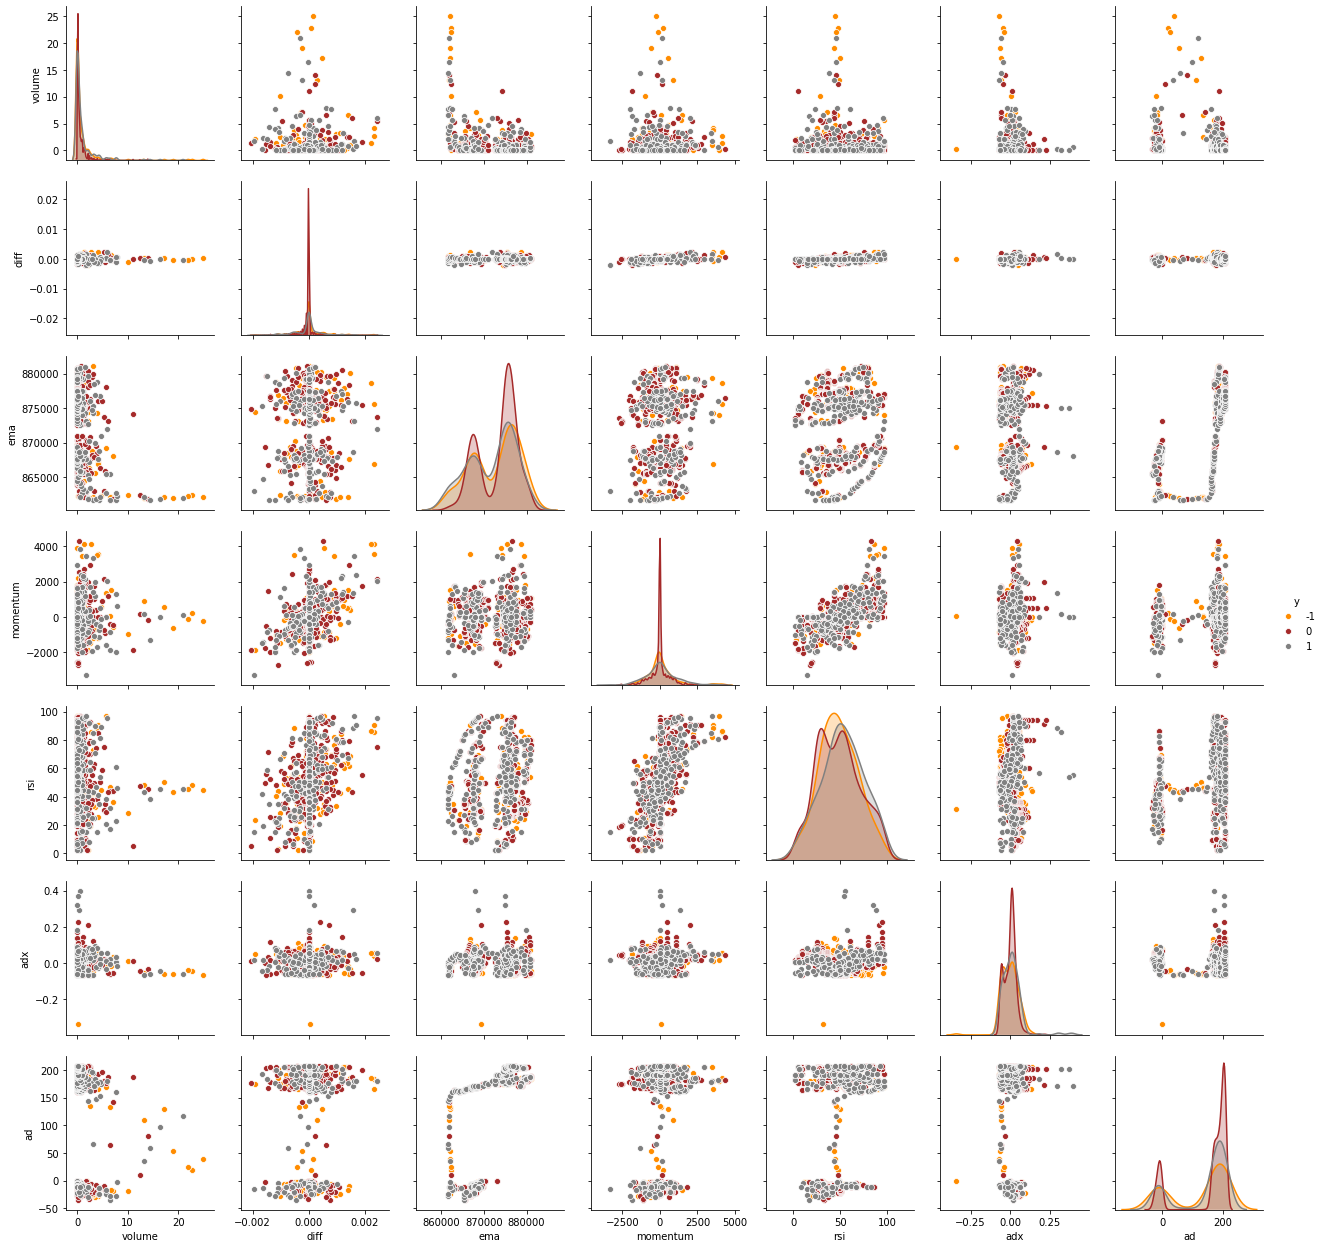

In [10]:
# seaborn plot
import seaborn as sns
df_ml = X_.join(y_)
print(df_ml.dtypes)
print(df_ml['y'].value_counts())
sns.pairplot(df_ml, hue='y', vars=['volume', 'diff', 'ema', 'momentum', 'rsi', 'adx', 'ad'], palette={1: 'gray', 0: 'brown', -1: 'darkorange'})

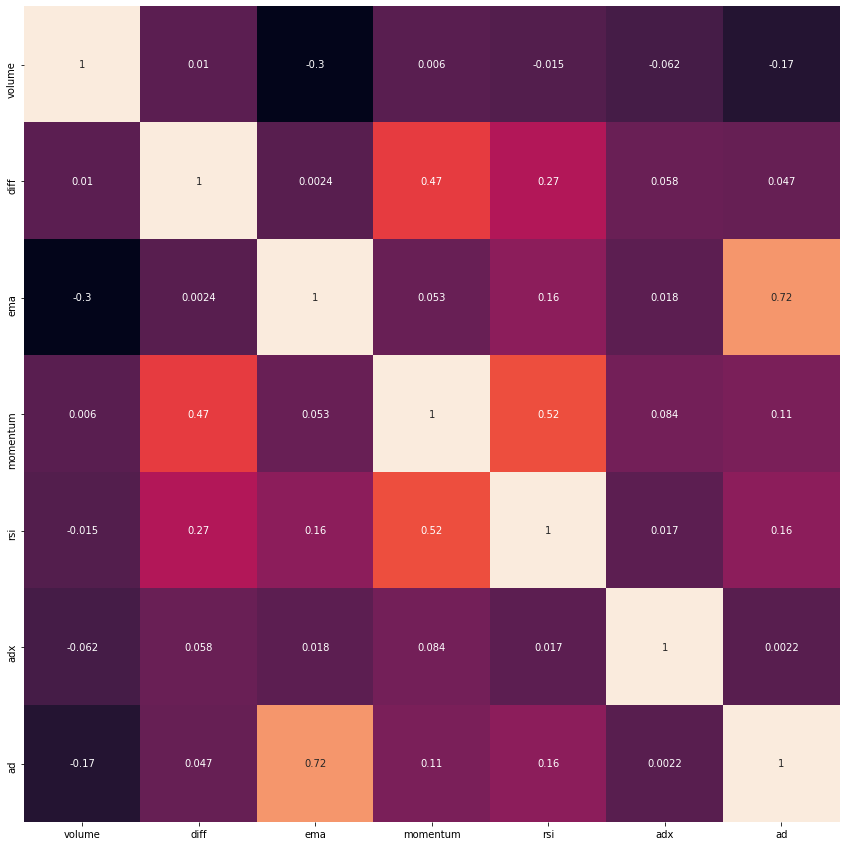

In [11]:
# heatmap plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(X_.astype(float).corr(), vmax=1.0, square=True, linecolor='white', annot=True, ax=ax, cbar=False)

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

pipe_knn = Pipeline([('scl', StandardScaler()), ('est', KNeighborsClassifier(n_neighbors=3))])
pipe_logistic = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=39))])
pipe_rf = Pipeline([('scl', StandardScaler()), ('est', RandomForestClassifier(random_state=39))])
pipe_gb = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])

pipe_names = ['KNN','Logistic','RandomForest','GradientBoosting']
pipe_lines = [pipe_knn, pipe_logistic, pipe_rf, pipe_gb]

for (i, pipe) in enumerate(pipe_lines):
    pipe.fit(X_train, y_train.values.ravel())
    print(pipe)
    print('%s: %.3f' % (pipe_names[i] + ' Train Accuracy', accuracy_score(y_train.values.ravel(), pipe.predict(X_train))))
    print('%s: %.3f' % (pipe_names[i] + ' Test Accuracy', accuracy_score(y_test.values.ravel(), pipe.predict(X_test))))
    print('%s: %.3f' % (pipe_names[i] + ' Train F1 Score', f1_score(y_train.values.ravel(), pipe.predict(X_train), average='micro')))
    print('%s: %.3f' % (pipe_names[i] + ' Test F1 Score', f1_score(y_test.values.ravel(), pipe.predict(X_test), average='micro')))

X_train shape: (964, 7)
X_test shape: (476, 7)
y_train shape: (964, 1)
y_test shape: (476, 1)
Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('est',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)
KNN Train Accuracy: 0.834
KNN Test Accuracy: 0.679
KNN Train F1 Score: 0.834
KNN Test F1 Score: 0.679
Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('est',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_ite

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('est',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            presort='auto', random_state=39,
   

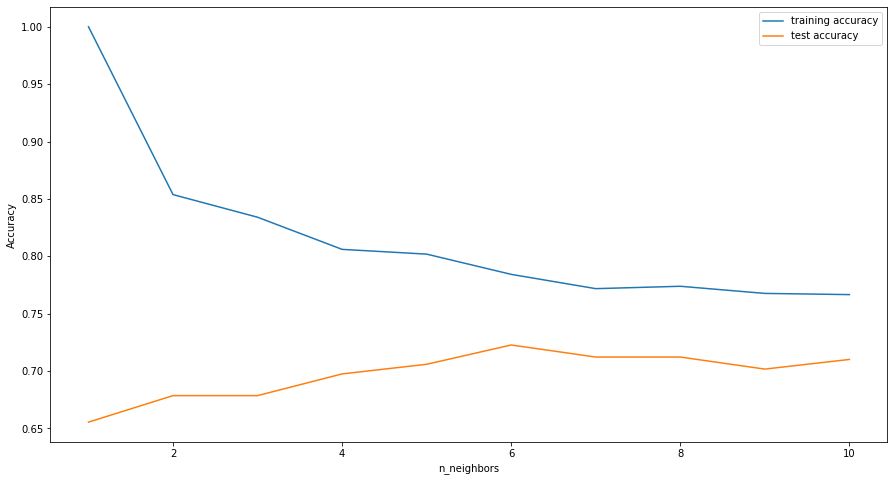

In [16]:
# KNeighbor classifier parameter
knn_training_accuracy = []
knn_test_accuracy = []
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    knn = Pipeline([('scl', StandardScaler()), ('est', KNeighborsClassifier(n_neighbors=n_neighbors))])
    knn.fit(X_train, y_train.values.ravel())
    knn_training_accuracy.append(knn.score(X_train, y_train.values.ravel()))
    knn_test_accuracy.append(knn.score(X_test, y_test.values.ravel()))
    
plt.figure(figsize=(15,8))
plt.plot(neighbors_settings, knn_training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, knn_test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

Training set score C=100: 0.733
Test set score C=100: 0.725
Training set score C=0.01: 0.729
Test set score C=0.01: 0.718
Coefficiency for each label: [[ 0.19007832  0.08319113  0.37835789 -0.0389602  -0.13544865 -0.09939254
  -0.34985414]
 [-0.35626383  0.05768856 -0.0744448   0.01589792 -0.07316887 -0.08930747
   0.15261085]
 [ 0.16618551 -0.14087969 -0.30391309  0.02306228  0.20861752  0.18870001
   0.19724329]]
Classes for the model: [-1  0  1]


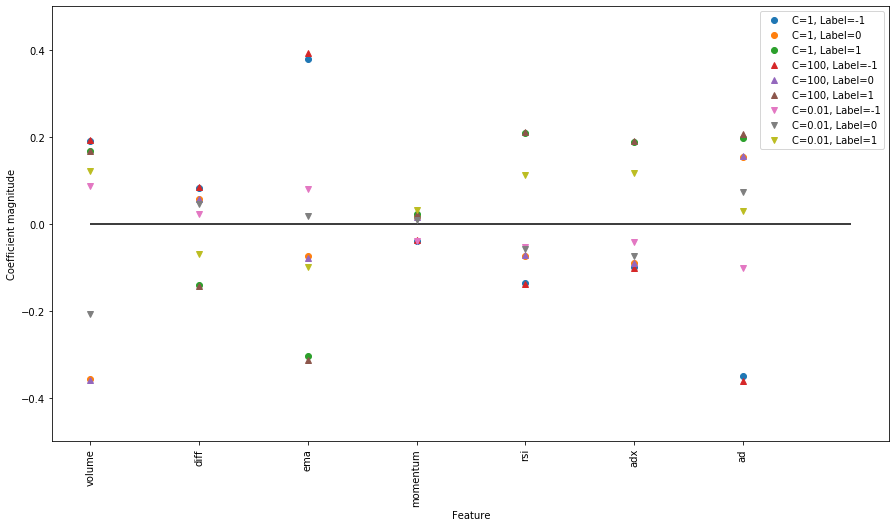

In [37]:
# Logistic Regression parameter
pipe_logistic100 = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(C=100, solver='lbfgs', multi_class='multinomial', random_state=39))])
pipe_logistic001 = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(C=0.01, solver='lbfgs', multi_class='multinomial', random_state=39))])

pipe_logistic100.fit(X_train, y_train.values.ravel())
pipe_logistic001.fit(X_train, y_train.values.ravel())
print("Training set score C=100: {:.3f}".format(pipe_logistic100.score(X_train, y_train.values.ravel())))
print("Test set score C=100: {:.3f}".format(pipe_logistic100.score(X_test, y_test.values.ravel())))
print("Training set score C=0.01: {:.3f}".format(pipe_logistic001.score(X_train, y_train.values.ravel())))
print("Test set score C=0.01: {:.3f}".format(pipe_logistic001.score(X_test, y_test.values.ravel())))

print('Coefficiency for each label: {}'.format(pipe_logistic.named_steps['est'].coef_))
print('Classes for the model: {}'.format(pipe_logistic.named_steps['est'].classes_))

plt.figure(figsize=(15,8))
plt.plot(pipe_logistic.named_steps['est'].coef_[0].T, 'o', label='C=1, Label=-1')
plt.plot(pipe_logistic.named_steps['est'].coef_[1].T, 'o', label='C=1, Label=0')
plt.plot(pipe_logistic.named_steps['est'].coef_[2].T, 'o', label='C=1, Label=1')
plt.plot(pipe_logistic100.named_steps['est'].coef_[0].T, '^', label='C=100, Label=-1')
plt.plot(pipe_logistic100.named_steps['est'].coef_[1].T, '^', label='C=100, Label=0')
plt.plot(pipe_logistic100.named_steps['est'].coef_[2].T, '^', label='C=100, Label=1')
plt.plot(pipe_logistic001.named_steps['est'].coef_[0].T, 'v', label='C=0.01, Label=-1')
plt.plot(pipe_logistic001.named_steps['est'].coef_[1].T, 'v', label='C=0.01, Label=0')
plt.plot(pipe_logistic001.named_steps['est'].coef_[2].T, 'v', label='C=0.01, Label=1')
plt.xticks(range(X_.shape[1]), X_.columns, rotation=90)
plt.hlines(0, 0, X_.shape[1])
plt.ylim(-0.5, 0.5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

Training set score C=100: 0.733
Test set score C=100: 0.725
Training set score C=0.01: 0.728
Test set score C=0.01: 0.714
Coefficiency for each label: [[ 0.01515947  0.01119413  0.41772055 -0.04584187 -0.05147724  0.
  -0.47591533]
 [-0.51789993  0.          0.          0.          0.          0.
   0.        ]
 [ 0.         -0.18761607 -0.21209732  0.          0.27883685  0.27347487
   0.02747878]]
Classes for the model: [-1  0  1]


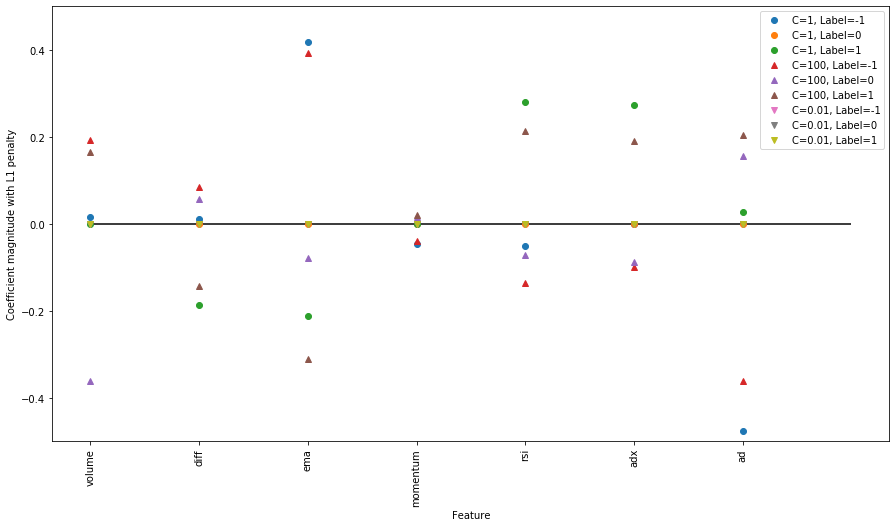

In [39]:
# Logistic Regression parameter L1 penalty
pipe_logistic =  Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(solver='saga', multi_class='multinomial', penalty="l1", random_state=39))])
pipe_logistic100 = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(C=100, solver='saga', multi_class='multinomial', penalty="l1", random_state=39))])
pipe_logistic001 = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(C=0.01, solver='saga', multi_class='multinomial', penalty="l1", random_state=39))])

pipe_logistic.fit(X_train, y_train.values.ravel())
pipe_logistic100.fit(X_train, y_train.values.ravel())
pipe_logistic001.fit(X_train, y_train.values.ravel())
print("Training set score C=100: {:.3f}".format(pipe_logistic100.score(X_train, y_train.values.ravel())))
print("Test set score C=100: {:.3f}".format(pipe_logistic100.score(X_test, y_test.values.ravel())))
print("Training set score C=0.01: {:.3f}".format(pipe_logistic001.score(X_train, y_train.values.ravel())))
print("Test set score C=0.01: {:.3f}".format(pipe_logistic001.score(X_test, y_test.values.ravel())))

print('Coefficiency for each label: {}'.format(pipe_logistic.named_steps['est'].coef_))
print('Classes for the model: {}'.format(pipe_logistic.named_steps['est'].classes_))

plt.figure(figsize=(15,8))
plt.plot(pipe_logistic.named_steps['est'].coef_[0].T, 'o', label='C=1, Label=-1')
plt.plot(pipe_logistic.named_steps['est'].coef_[1].T, 'o', label='C=1, Label=0')
plt.plot(pipe_logistic.named_steps['est'].coef_[2].T, 'o', label='C=1, Label=1')
plt.plot(pipe_logistic100.named_steps['est'].coef_[0].T, '^', label='C=100, Label=-1')
plt.plot(pipe_logistic100.named_steps['est'].coef_[1].T, '^', label='C=100, Label=0')
plt.plot(pipe_logistic100.named_steps['est'].coef_[2].T, '^', label='C=100, Label=1')
plt.plot(pipe_logistic001.named_steps['est'].coef_[0].T, 'v', label='C=0.01, Label=-1')
plt.plot(pipe_logistic001.named_steps['est'].coef_[1].T, 'v', label='C=0.01, Label=0')
plt.plot(pipe_logistic001.named_steps['est'].coef_[2].T, 'v', label='C=0.01, Label=1')
plt.xticks(range(X_.shape[1]), X_.columns, rotation=90)
plt.hlines(0, 0, X_.shape[1])
plt.ylim(-0.5, 0.5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude with L1 penalty")
plt.legend()

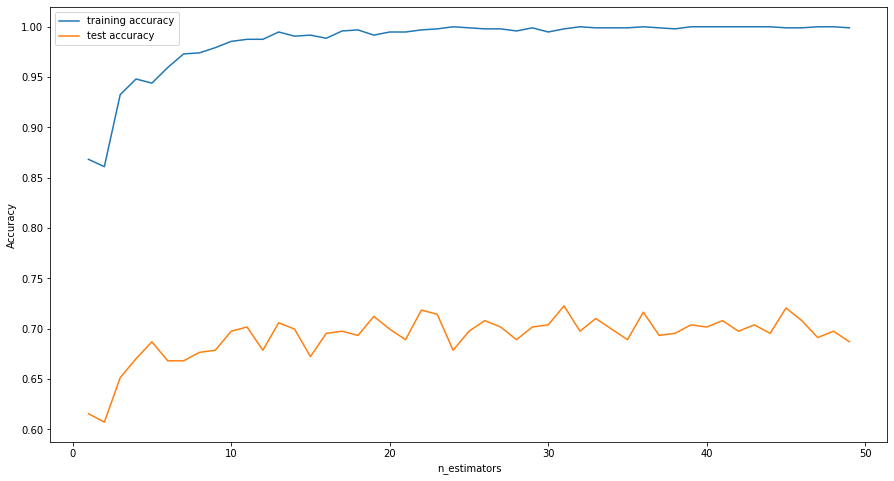

In [40]:
# Random forest classifier parameter
rf_training_accuracy = []
rf_test_accuracy = []
rf_settings = range(1, 50)

for n_estimators in rf_settings:
    rf = Pipeline([('scl', StandardScaler()), ('est', RandomForestClassifier(n_estimators=n_estimators))])
    rf.fit(X_train, y_train.values.ravel())
    rf_training_accuracy.append(rf.score(X_train, y_train.values.ravel()))
    rf_test_accuracy.append(rf.score(X_test, y_test.values.ravel()))
    
plt.figure(figsize=(15,8))
plt.plot(rf_settings, rf_training_accuracy, label="training accuracy")
plt.plot(rf_settings, rf_test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature importances:
[0.1195416  0.16275022 0.13017557 0.14000623 0.14624394 0.18440812
 0.11687433]


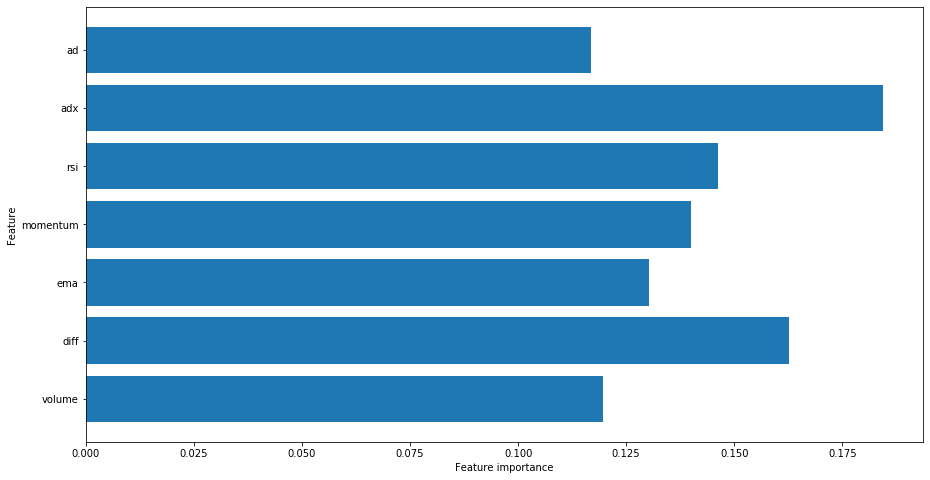

In [41]:
pipe_rf_10 = Pipeline([('scl', StandardScaler()), ('est', RandomForestClassifier(random_state=39))])
pipe_rf_10.fit(X_train, y_train.values.ravel())
importances = pipe_rf_10.named_steps['est'].feature_importances_

print("Feature importances:\n{}".format(pipe_rf_10.named_steps['est'].feature_importances_))
def plot_feature_importances(model, df):
    n_features = len(df.columns)
    plt.figure(figsize=(15, 8))
    plt.barh(range(n_features), model.named_steps['est'].feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(pipe_rf_10, X_)

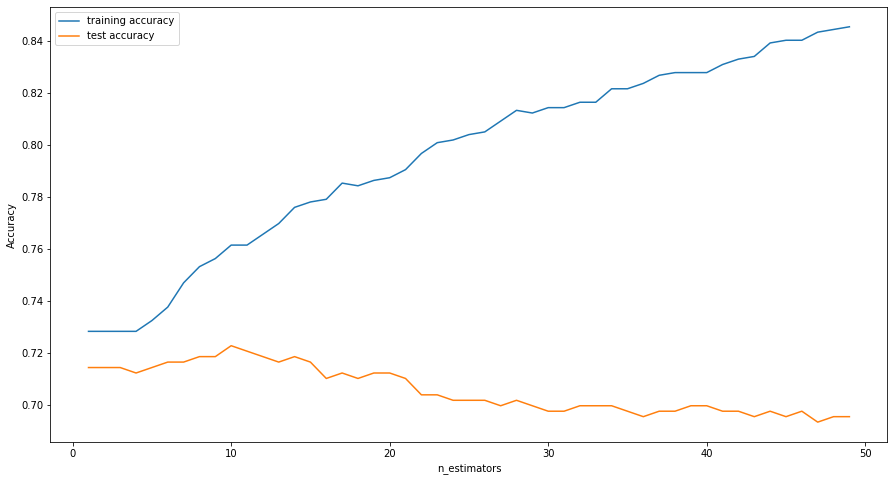

In [42]:
# GradientBoost classifier parameter n_estimators
gb_training_accuracy = []
gb_test_accuracy = []
gb_settings = range(1, 50)

for n_estimators in gb_settings:
    gb = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(n_estimators=n_estimators))])
    gb.fit(X_train, y_train.values.ravel())
    gb_training_accuracy.append(gb.score(X_train, y_train.values.ravel()))
    gb_test_accuracy.append(gb.score(X_test, y_test.values.ravel()))
    
plt.figure(figsize=(15,8))
plt.plot(gb_settings, gb_training_accuracy, label="training accuracy")
plt.plot(gb_settings, gb_test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

Feature importances:
[0.24068766 0.37769999 0.03236548 0.09592139 0.05731779 0.1655501
 0.03045759]


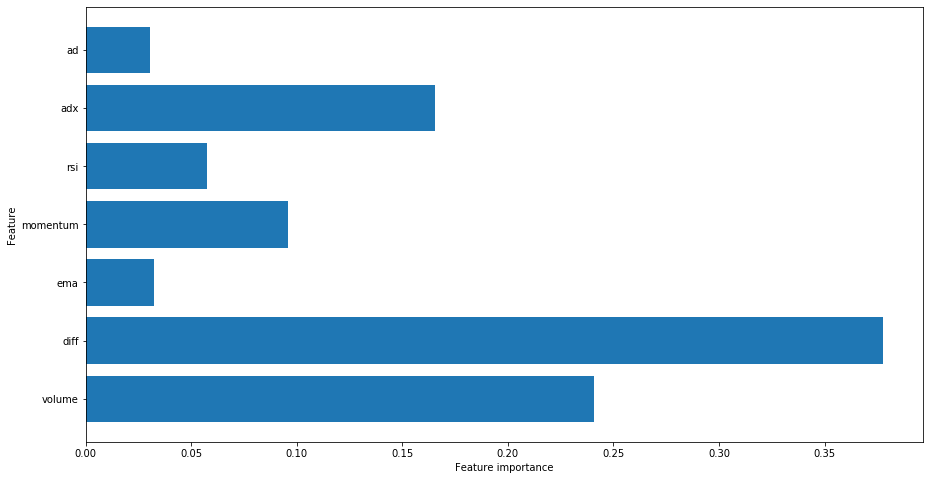

In [43]:
pipe_gb_alt = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(n_estimators=5, random_state=39))])
pipe_gb_alt.fit(X_train, y_train.values.ravel())
importances = pipe_gb_alt.named_steps['est'].feature_importances_

print("Feature importances:\n{}".format(pipe_gb_alt.named_steps['est'].feature_importances_))
def plot_feature_importances(model, df):
    n_features = len(df.columns)
    plt.figure(figsize=(15, 8))
    plt.barh(range(n_features), model.named_steps['est'].feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(pipe_gb_alt, X_)

In [44]:
# Support Vector Machine
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()), ('est', SVC(kernel='rbf', C=100, gamma=10.0, random_state=39))])
pipe_svc.fit(X_train, y_train.values.ravel())
print("Accuracy on training set: {:.3f}".format(pipe_svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(pipe_svc.score(X_test, y_test)))

Accuracy on training set: 0.999
Accuracy on test set: 0.69


In [45]:
# MLP classifier
from sklearn.neural_network import MLPClassifier
pipe_mlp = Pipeline([('scl', StandardScaler()), ('est', MLPClassifier(solver='lbfgs', random_state=0))])
pipe_mlp.fit(X_train, y_train.values.ravel())
print("Accuracy on training set: {:.3f}".format(pipe_mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipe_mlp.score(X_test, y_test)))

Accuracy on training set: 0.978
Accuracy on test set: 0.687


In [46]:
# feature calculation
open = pd.Series(df['open'])
high = pd.Series(df['high'])
low = pd.Series(df['low'])
close = pd.Series(df['close'])
volume = pd.Series(df['volume'])

# pct_change for new column
X['diff'] = y

## Overlap Studies Functions
# DEMA - Double Exponential Moving Average
dema = talib.DEMA(close, timeperiod=3)
dema = dema.fillna(dema.mean())
print('DEMA - Double Exponential Moving Average shape: {}'.format(dema.shape))

# EMA - Exponential Moving Average
ema = talib.EMA(close, timeperiod=3)
ema = ema.fillna(ema.mean())
print('EMA - Exponential Moving Average shape: {}'.format(ema.shape))

# HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
hilbert = talib.HT_TRENDLINE(close)
hilbert = hilbert.fillna(hilbert.mean())
print('HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline shape: {}'.format(hilbert.shape))

# KAMA - Kaufman Adaptive Moving Average
kama = talib.KAMA(close, timeperiod=3)
kama = kama.fillna(kama.mean())
print('KAMA - Kaufman Adaptive Moving Average shape: {}'.format(kama.shape))

# MA - Moving average
ma = talib.MA(close, timeperiod=3, matype=0)
ma = ma.fillna(ma.mean())
print('MA - Moving average shape: {}'.format(kama.shape))

# MIDPOINT - MidPoint over period
midpoint = talib.MIDPOINT(close, timeperiod=7)
midpoint = midpoint.fillna(midpoint.mean())
print('MIDPOINT - MidPoint over period shape: {}'.format(midpoint.shape))

# MIDPRICE - Midpoint Price over period
midprice = talib.MIDPRICE(high, low, timeperiod=7)
midprice = midprice.fillna(midprice.mean())
print('MIDPRICE - Midpoint Price over period shape: {}'.format(midprice.shape))

# SAR - Parabolic SAR
sar = talib.SAR(high, low, acceleration=0, maximum=0)
sar = sar.fillna(sar.mean())
print('SAR - Parabolic SAR shape: {}'.format(sar.shape))

# SAREXT - Parabolic SAR - Extended
sarext = talib.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
sarext = sarext.fillna(sarext.mean())
print('SAREXT - Parabolic SAR - Extended shape: {}'.format(sarext.shape))

# SMA - Simple Moving Average
sma = talib.SMA(close, timeperiod=3)
sma = sma.fillna(sma.mean())
print('SMA - Simple Moving Average shape: {}'.format(sma.shape))

# T3 - Triple Exponential Moving Average (T3)
t3 = talib.T3(close, timeperiod=5, vfactor=0)
t3 = t3.fillna(t3.mean())
print('T3 - Triple Exponential Moving Average shape: {}'.format(t3.shape))

# TEMA - Triple Exponential Moving Average
tema = talib.TEMA(close, timeperiod=3)
tema = tema.fillna(tema.mean())
print('TEMA - Triple Exponential Moving Average shape: {}'.format(tema.shape))

# TRIMA - Triangular Moving Average
trima = talib.TRIMA(close, timeperiod=3)
trima = trima.fillna(trima.mean())
print('TRIMA - Triangular Moving Average shape: {}'.format(trima.shape))

# WMA - Weighted Moving Average
wma = talib.WMA(close, timeperiod=3)
wma = wma.fillna(wma.mean())
print('WMA - Weighted Moving Average shape: {}'.format(wma.shape))

## Momentum Indicator Functions
# ADX - Average Directional Movement Index
adx = talib.ADX(high, low, close, timeperiod=14)
adx = adx.fillna(adx.mean())
print('ADX - Average Directional Movement Index shape: {}'.format(adx.shape))

# ADXR - Average Directional Movement Index Rating
adxr = talib.ADXR(high, low, close, timeperiod=7)
adxr = adxr.fillna(adxr.mean())
print('ADXR - Average Directional Movement Index Rating shape: {}'.format(adxr.shape))

# APO - Absolute Price Oscillator
apo = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
apo = apo.fillna(apo.mean())
print('APO - Absolute Price Oscillator shape: {}'.format(apo.shape))

# AROONOSC - Aroon Oscillator
aroon = talib.AROONOSC(high, low, timeperiod=14)
aroon = aroon.fillna(aroon.mean())
print('AROONOSC - Aroon Oscillator shape: {}'.format(apo.shape))

# BOP - Balance Of Power
bop = talib.BOP(open, high, low, close)
bop = bop.fillna(bop.mean())
print('BOP - Balance Of Power shape: {}'.format(apo.shape))

# CCI - Commodity Channel Index
cci = talib.CCI(high, low, close, timeperiod=7)
cci = cci.fillna(cci.mean())
print('CCI - Commodity Channel Index shape: {}'.format(cci.shape))

# CMO - Chande Momentum Oscillator
cmo = talib.CMO(close, timeperiod=7)
cmo = cmo.fillna(cmo.mean())
print('CMO - Chande Momentum Oscillator shape: {}'.format(cmo.shape))

# DX - Directional Movement Index
dx = talib.DX(high, low, close, timeperiod=7)
dx = dx.fillna(dx.mean())
print('DX - Directional Movement Index shape: {}'.format(dx.shape))

# MFI - Money Flow Index
mfi = talib.MFI(high, low, close, volume, timeperiod=7)
mfi = mfi.fillna(mfi.mean())
print('MFI - Money Flow Index shape: {}'.format(mfi.shape))

# MINUS_DI - Minus Directional Indicator
minusdi = talib.MINUS_DI(high, low, close, timeperiod=14)
minusdi = minusdi.fillna(minusdi.mean())
print('MINUS_DI - Minus Directional Indicator shape: {}'.format(minusdi.shape))

# MINUS_DM - Minus Directional Movement
minusdm = talib.MINUS_DM(high, low, timeperiod=14)
minusdm = minusdm.fillna(minusdm.mean())
print('MINUS_DM - Minus Directional Movement shape: {}'.format(minusdm.shape))

# MOM - Momentum
mom = talib.MOM(close, timeperiod=5)
mom = mom.fillna(mom.mean())
print('MOM - Momentum shape: {}'.format(mom.shape))

# PLUS_DI - Plus Directional Indicator
plusdi = talib.PLUS_DI(high, low, close, timeperiod=14)
plusdi = plusdi.fillna(plusdi.mean())
print('PLUS_DI - Plus Directional Indicator shape: {}'.format(plusdi.shape))

# PLUS_DM - Plus Directional Movement
plusdm = talib.PLUS_DM(high, low, timeperiod=14)
plusdm = plusdm.fillna(plusdm.mean())
print('PLUS_DM - Plus Directional Movement shape: {}'.format(plusdi.shape))

# PPO - Percentage Price Oscillator
ppo = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
ppo = ppo.fillna(ppo.mean())
print('PPO - Percentage Price Oscillator shape: {}'.format(ppo.shape))

# ROC - Rate of change:((price/prevPrice)-1)*100
roc = talib.ROC(close, timeperiod=10)
roc = roc.fillna(roc.mean())
print('ROC - Rate of change : ((price/prevPrice)-1)*100 shape: {}'.format(roc.shape))

# RSI - Relative Strength Index
rsi = talib.RSI(close, timeperiod=14)
rsi = rsi.fillna(rsi.mean())
print('RSI - Relative Strength Index shape: {}'.format(rsi.shape))

# TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
trix = talib.TRIX(close, timeperiod=30)
trix = trix.fillna(trix.mean())
print('TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA shape: {}'.format(trix.shape))

# ULTOSC - Ultimate Oscillator
ultosc = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
ultosc = ultosc.fillna(ultosc.mean())
print('ULTOSC - Ultimate Oscillator shape: {}'.format(ultosc.shape))

# WILLR - Williams'%R
willr = talib.WILLR(high, low, close, timeperiod=7)
willr = willr.fillna(willr.mean())
print("WILLR - Williams'%R shape: {}".format(willr.shape))

## Volume Indicator Functions
# AD - Chaikin A/D Line
ad = talib.AD(high, low, close, volume)
ad = ad.fillna(ad.mean())
print('AD - Chaikin A/D Line shape: {}'.format(ad.shape))
      
# ADOSC - Chaikin A/D Oscillator
adosc = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
adosc = adosc.fillna(adosc.mean())
print('ADOSC - Chaikin A/D Oscillator shape: {}'.format(adosc.shape))

# OBV - On Balance Volume
obv = talib.OBV(close, volume)
obv = obv.fillna(obv.mean())
print('OBV - On Balance Volume shape: {}'.format(obv.shape))

## Volatility Indicator Functions
# ATR - Average True Range
atr = talib.ATR(high, low, close, timeperiod=7)
atr = atr.fillna(atr.mean())
print('ATR - Average True Range shape: {}'.format(atr.shape))

# NATR - Normalized Average True Range
natr = talib.NATR(high, low, close, timeperiod=7)
natr = natr.fillna(natr.mean())
print('NATR - Normalized Average True Range shape: {}'.format(natr.shape))

# TRANGE - True Range
trange = talib.TRANGE(high, low, close)
trange = trange.fillna(trange.mean())
print('TRANGE - True Range shape: {}'.format(natr.shape))

## Price Transform Functions
# AVGPRICE - Average Price
avg = talib.AVGPRICE(open, high, low, close)
avg = avg.fillna(avg.mean())
print('AVGPRICE - Average Price shape: {}'.format(natr.shape))

# MEDPRICE - Median Price
medprice = talib.MEDPRICE(high, low)
medprice = medprice.fillna(medprice.mean())
print('MEDPRICE - Median Price shape: {}'.format(medprice.shape))

# TYPPRICE - Typical Price
typ = talib.TYPPRICE(high, low, close)
typ = typ.fillna(typ.mean())
print('TYPPRICE - Typical Price shape: {}'.format(typ.shape))

# WCLPRICE - Weighted Close Price
wcl = talib.WCLPRICE(high, low, close)
wcl = wcl.fillna(wcl.mean())
print('WCLPRICE - Weighted Close Price shape: {}'.format(wcl.shape))

## Cycle Indicator Functions
# HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
dcperiod = talib.HT_DCPERIOD(close)
dcperiod = dcperiod.fillna(dcperiod.mean())
print('HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period shape: {}'.format(dcperiod.shape))

# HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
dcphase = talib.HT_DCPHASE(close)
dcphase = dcphase.fillna(dcphase.mean())
print('HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase shape: {}'.format(dcperiod.shape))

## Statistic Functions
# BETA - Beta
beta = talib.BETA(high, low, timeperiod=3)
beta = beta.fillna(beta.mean())
print('BETA - Beta shape: {}'.format(beta.shape))

# CORREL - Pearson's Correlation Coefficient(r)
correl = talib.CORREL(high, low, timeperiod=30)
correl = correl.fillna(correl.mean())
print("CORREL - Pearson's Correlation Coefficient(r) shape: {}".format(beta.shape))

# LINEARREG - Linear Regression
linreg = talib.LINEARREG(close, timeperiod=7)
linreg = linreg.fillna(linreg.mean())
print("LINEARREG - Linear Regression shape: {}".format(linreg.shape))

# STDDEV - Standard Deviation
stddev = talib.STDDEV(close, timeperiod=5, nbdev=1)
stddev = stddev.fillna(stddev.mean())
print("STDDEV - Standard Deviation shape: {}".format(stddev.shape))

# TSF - Time Series Forecast
tsf = talib.TSF(close, timeperiod=7)
tsf = tsf.fillna(tsf.mean())
print("TSF - Time Series Forecast shape: {}".format(tsf.shape))

# VAR - Variance
var = talib.VAR(close, timeperiod=5, nbdev=1)
var = var.fillna(var.mean())
print("VAR - Variance shape: {}".format(var.shape))

## Feature DataFrame
X_full = pd.concat([X, dema, ema, hilbert, kama, ma, midpoint, midprice, sar, sarext, sma, t3, tema, trima, wma, adx, adxr,
                    apo, aroon, bop, cci, cmo, mfi, minusdi, minusdm, mom, plusdi, plusdm, ppo, roc, rsi, trix, ultosc, willr,
                    ad, adosc, obv, atr, natr, trange, avg, medprice, typ, wcl, dcperiod, dcphase, beta, correl, linreg, stddev,
                    tsf, var], axis=1).drop(['open', 'high', 'low', 'close'], axis=1)
X_full.columns = ['volume','diff', 'dema', 'ema', 'hilbert', 'kama', 'ma', 'midpoint', 'midprice', 'sar', 'sarext', 'sma',
                  't3', 'tema', 'trima', 'wma', 'adx', 'adxr', 'apo', 'aroon', 'bop', 'cci', 'cmo', 'mfi', 'minusdi', 'minusdm',
                  'mom', 'plusdi', 'plusdm', 'ppo', 'roc', 'rsi', 'trix', 'ultosc', 'willr', 'ad', 'adosc', 'obv', 'atr', 'natr',
                  'trange', 'avg', 'medprice', 'typ', 'wcl', 'dcperiod', 'dcphase', 'beta', 'correl', 'linreg', 'stddev', 'tsf', 'var']
X_full.join(y_).head(10)

DEMA - Double Exponential Moving Average shape: (1440,)
EMA - Exponential Moving Average shape: (1440,)
HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline shape: (1440,)
KAMA - Kaufman Adaptive Moving Average shape: (1440,)
MA - Moving average shape: (1440,)
MIDPOINT - MidPoint over period shape: (1440,)
MIDPRICE - Midpoint Price over period shape: (1440,)
SAR - Parabolic SAR shape: (1440,)
SAREXT - Parabolic SAR - Extended shape: (1440,)
SMA - Simple Moving Average shape: (1440,)
T3 - Triple Exponential Moving Average shape: (1440,)
TEMA - Triple Exponential Moving Average shape: (1440,)
TRIMA - Triangular Moving Average shape: (1440,)
WMA - Weighted Moving Average shape: (1440,)
ADX - Average Directional Movement Index shape: (1440,)
ADXR - Average Directional Movement Index Rating shape: (1440,)
APO - Absolute Price Oscillator shape: (1440,)
AROONOSC - Aroon Oscillator shape: (1440,)
BOP - Balance Of Power shape: (1440,)
CCI - Commodity Channel Index shape: (1440,)
CMO - Cha

,volume,diff,dema,ema,hilbert,kama,ma,midpoint,midprice,sar,...,wcl,dcperiod,dcphase,beta,correl,linreg,stddev,tsf,var,y
2019-10-17 00:00:00,0.0401,0.000000,873115.037668,873106.507231,873194.409284,873106.256047,873106.501623,873099.383194,873089.147838,863630.822099,...,870417.50,23.218668,119.30113,0.098520,0.854392,873118.826584,182.545527,873123.638075,87499.396544,0
2019-10-17 00:01:01,0.0462,0.000000,873115.037668,873106.507231,873194.409284,873106.256047,873106.501623,873099.383194,873089.147838,870414.000000,...,870413.25,23.218668,119.30113,0.098520,0.854392,873118.826584,182.545527,873123.638075,87499.396544,0
2019-10-17 00:02:02,0.0900,0.000000,873115.037668,870413.000000,873194.409284,873106.256047,870413.000000,873099.383194,873089.147838,870414.000000,...,870413.00,23.218668,119.30113,0.098520,0.854392,873118.826584,182.545527,873123.638075,87499.396544,0
2019-10-17 00:03:03,0.0149,0.000000,873115.037668,870413.000000,873194.409284,870413.000000,870413.000000,873099.383194,873089.147838,870414.000000,...,870413.00,23.218668,119.30113,0.000000,0.854392,873118.826584,182.545527,873123.638075,87499.396544,0
2019-10-17 00:04:04,0.1723,0.000000,870413.000000,870413.000000,873194.409284,870413.000000,870413.000000,873099.383194,873089.147838,870414.000000,...,870412.75,23.218668,119.30113,0.000000,0.854392,873118.826584,0.000000,873123.638075,0.000000,0
2019-10-17 00:05:05,0.2110,-0.000001,870412.250000,870412.500000,873194.409284,870412.555556,870412.666667,873099.383194,873089.147838,870414.000000,...,870412.25,23.218668,119.30113,0.000000,0.854392,873118.826584,0.399890,873123.638075,0.159912,0
2019-10-17 00:06:06,1.7049,0.000000,870412.000000,870412.250000,873194.409284,870412.308642,870412.333333,870412.500000,870421.500000,870414.000000,...,870412.00,23.218668,119.30113,0.000000,0.854392,870412.178571,0.489888,870412.000000,0.239990,0
2019-10-17 00:07:07,1.8763,0.000000,870411.937500,870412.125000,873194.409284,870412.171468,870412.000000,870412.500000,870413.000000,870414.000000,...,870412.00,23.218668,119.30113,0.000000,0.854392,870411.928571,0.489888,870411.714286,0.239990,-1
2019-10-17 00:08:08,1.9904,-0.000474,870102.187500,870205.562500,873194.409284,870228.539704,870274.333333,870206.000000,870206.000000,870414.000000,...,870102.25,23.218668,119.30113,0.000000,0.854392,870220.035714,165.300454,870175.571429,27324.240112,-1
2019-10-17 00:09:09,0.0400,-0.001567,868976.703125,869420.781250,873194.409284,869520.744280,869682.333333,869524.500000,869524.500000,870414.000000,...,868976.75,23.218668,119.30113,2.801809,0.854392,869439.678571,687.953603,869219.714286,473280.160156,0


In [86]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_, test_size=0.33, random_state=42)
print('X_train shape: {}'.format(X_train_full.shape))
print('X_test shape: {}'.format(X_test_full.shape))
print('y_train shape: {}'.format(y_train_full.shape))
print('y_test shape: {}'.format(y_test_full.shape))

pipe_knn_full = Pipeline([('scl', StandardScaler()), ('est', KNeighborsClassifier(n_neighbors=3))])
pipe_logistic_full = Pipeline([('scl', StandardScaler()), ('est', LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=39))])
pipe_rf_full = Pipeline([('scl', StandardScaler()), ('est', RandomForestClassifier(random_state=39))])
pipe_gb_full = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])

pipe_names = ['KNN','Logistic','RandomForest','GradientBoosting']
pipe_lines_full = [pipe_knn_full, pipe_logistic_full, pipe_rf_full, pipe_gb_full]

for (i, pipe) in enumerate(pipe_lines_full):
    pipe.fit(X_train_full, y_train_full.values.ravel())
    print(pipe)
    print('%s: %.3f' % (pipe_names[i] + ' Train Accuracy', accuracy_score(y_train_full.values.ravel(), pipe.predict(X_train_full))))
    print('%s: %.3f' % (pipe_names[i] + ' Test Accuracy', accuracy_score(y_test_full.values.ravel(), pipe.predict(X_test_full))))
    print('%s: %.3f' % (pipe_names[i] + ' Train F1 Score', f1_score(y_train_full.values.ravel(), pipe.predict(X_train_full), average='micro')))
    print('%s: %.3f' % (pipe_names[i] + ' Test F1 Score', f1_score(y_test_full.values.ravel(), pipe.predict(X_test_full), average='micro')))

X_train shape: (964, 53)
X_test shape: (476, 53)
y_train shape: (964, 1)
y_test shape: (476, 1)
Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('est',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)
KNN Train Accuracy: 0.821
KNN Test Accuracy: 0.660
KNN Train F1 Score: 0.821
KNN Test F1 Score: 0.660


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('est',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=39,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Logistic Train Accuracy: 0.744
Logistic Test Accuracy: 0.710
Logistic Train F1 Score: 0.744
Logistic Test F1 Score: 0.710
Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('est',
                 RandomForestClassifier(bootstrap=True, class_weight=No

[ True False False False  True False False False False False False False
 False False False False False False False False False  True False  True
 False  True False False  True False False False False  True False False
  True False  True  True  True False False False False False False False
 False False  True False  True]
--------------------------Without Univariate Statistics-------------------------------------
Train Accuracy: 0.930
Test Accuracy: 0.672
Train F1 Score: 0.930
Test F1 Score: 0.672
---------------------------With Univariate Statistics--------------------------------------
Train Accuracy: 0.895
Test Accuracy: 0.674
Train F1 Score: 0.895
Test F1 Score: 0.674


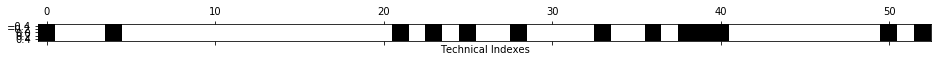

In [48]:
# Univariate Statistics
from sklearn.feature_selection import SelectPercentile
select = SelectPercentile(percentile=25)
select.fit(X_train_full, y_train_full.values.ravel())
X_train_selected = select.transform(X_train_full)
X_test_selected = select.transform(X_test_full)
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Technical Indexes")

# GradientBoost Classifier
print('--------------------------Without Univariate Statistics-------------------------------------')
pipe_gb = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
pipe_gb.fit(X_train_full, y_train_full.values.ravel())
print('Train Accuracy: {:.3f}'.format(accuracy_score(y_train_full.values.ravel(), pipe_gb.predict(X_train_full))))
print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test_full.values.ravel(), pipe_gb.predict(X_test_full))))
print('Train F1 Score: {:.3f}'.format(f1_score(y_train_full.values.ravel(), pipe_gb.predict(X_train_full), average='micro')))
print('Test F1 Score: {:.3f}'.format(f1_score(y_test_full.values.ravel(), pipe_gb.predict(X_test_full), average='micro')))

# GradientBoost Classifier with Univariate Statistics
print('---------------------------With Univariate Statistics--------------------------------------')
pipe_gb_percentile = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
pipe_gb_percentile.fit(X_train_selected, y_train_full.values.ravel())
print('Train Accuracy: {:.3f}'.format(accuracy_score(y_train_full.values.ravel(), pipe_gb_percentile.predict(X_train_selected))))
print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test_full.values.ravel(), pipe_gb_percentile.predict(X_test_selected))))
print('Train F1 Score: {:.3f}'.format(f1_score(y_train_full.values.ravel(), pipe_gb_percentile.predict(X_train_selected), average='micro')))
print('Test F1 Score: {:.3f}'.format(f1_score(y_test_full.values.ravel(), pipe_gb_percentile.predict(X_test_selected), average='micro')))

(964, 14)
[ True  True False False False False False False False False False False
 False False False False  True False False False False  True False False
 False False False False  True False False False  True False False False
 False  True  True  True  True False False False False  True False  True
 False False  True False  True]
--------------------------Without Model-based Selection-------------------------------------
Train Accuracy: 0.930
Test Accuracy: 0.672
Train F1 Score: 0.930
Test F1 Score: 0.672
----------------------------With Model-based Selection--------------------------------------
Train Accuracy: 0.916
Test Accuracy: 0.674
Train F1 Score: 0.916
Test F1 Score: 0.674


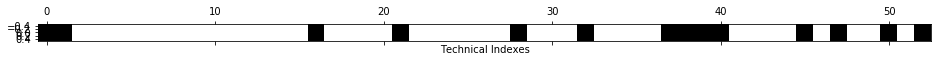

In [49]:
# Model-based Selection
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                        threshold="1.25*mean")
select.fit(X_train_full, y_train_full.values.ravel())
X_train_model = select.transform(X_train_full)
print(X_train_model.shape)
X_test_model = select.transform(X_test_full)
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Technical Indexes")

# GradientBoost Classifier
print('--------------------------Without Model-based Selection-------------------------------------')
pipe_gb = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
pipe_gb.fit(X_train_full, y_train_full.values.ravel())
print('Train Accuracy: {:.3f}'.format(accuracy_score(y_train_full.values.ravel(), pipe_gb.predict(X_train_full))))
print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test_full.values.ravel(), pipe_gb.predict(X_test_full))))
print('Train F1 Score: {:.3f}'.format(f1_score(y_train_full.values.ravel(), pipe_gb.predict(X_train_full), average='micro')))
print('Test F1 Score: {:.3f}'.format(f1_score(y_test_full.values.ravel(), pipe_gb.predict(X_test_full), average='micro')))

# GradientBoost Classifier with Model-based Selection
print('----------------------------With Model-based Selection--------------------------------------')
pipe_gb_model = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
pipe_gb_model.fit(X_train_model, y_train_full.values.ravel())
print('Train Accuracy: {:.3f}'.format(accuracy_score(y_train_full.values.ravel(), pipe_gb_model.predict(X_train_model))))
print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test_full.values.ravel(), pipe_gb_model.predict(X_test_model))))
print('Train F1 Score: {:.3f}'.format(f1_score(y_train_full.values.ravel(), pipe_gb_model.predict(X_train_model), average='micro')))
print('Test F1 Score: {:.3f}'.format(f1_score(y_test_full.values.ravel(), pipe_gb_model.predict(X_test_model), average='micro')))

[ True False False  True False False False False False False False False
 False False False False  True False False False False  True False False
  True False False False  True False  True False False False False False
  True  True  True  True  True False False False False False False False
  True False  True False  True]
--------------------------Without Recursive Feature Elimination-------------------------------------
Train Accuracy: 0.930
Test Accuracy: 0.672
Train F1 Score: 0.930
Test F1 Score: 0.672
----------------------------With Recursive Feature Elimination--------------------------------------
Train Accuracy: 0.916
Test Accuracy: 0.674
Train F1 Score: 0.916
Test F1 Score: 0.674


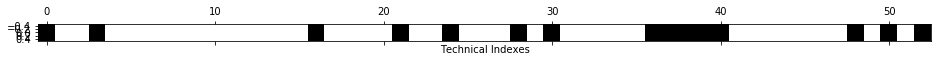

In [50]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=15)
select.fit(X_train_full, y_train_full.values.ravel())
X_train_rfe = select.transform(X_train_full)
X_test_rfe = select.transform(X_test_full)
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Technical Indexes")

# GradientBoost Classifier
print('--------------------------Without Recursive Feature Elimination-------------------------------------')
pipe_gb = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
pipe_gb.fit(X_train_full, y_train_full.values.ravel())
print('Train Accuracy: {:.3f}'.format(accuracy_score(y_train_full.values.ravel(), pipe_gb.predict(X_train_full))))
print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test_full.values.ravel(), pipe_gb.predict(X_test_full))))
print('Train F1 Score: {:.3f}'.format(f1_score(y_train_full.values.ravel(), pipe_gb.predict(X_train_full), average='micro')))
print('Test F1 Score: {:.3f}'.format(f1_score(y_test_full.values.ravel(), pipe_gb.predict(X_test_full), average='micro')))

# GradientBoost Classifier with Recursive Feature Elimination
print('----------------------------With Recursive Feature Elimination--------------------------------------')
pipe_gb_rfe = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
pipe_gb_rfe.fit(X_train_rfe, y_train_full.values.ravel())
print('Train Accuracy: {:.3f}'.format(accuracy_score(y_train_full.values.ravel(), pipe_gb_rfe.predict(X_train_rfe))))
print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test_full.values.ravel(), pipe_gb_rfe.predict(X_test_rfe))))
print('Train F1 Score: {:.3f}'.format(f1_score(y_train_full.values.ravel(), pipe_gb_rfe.predict(X_train_rfe), average='micro')))
print('Test F1 Score: {:.3f}'.format(f1_score(y_test_full.values.ravel(), pipe_gb_rfe.predict(X_test_rfe), average='micro')))

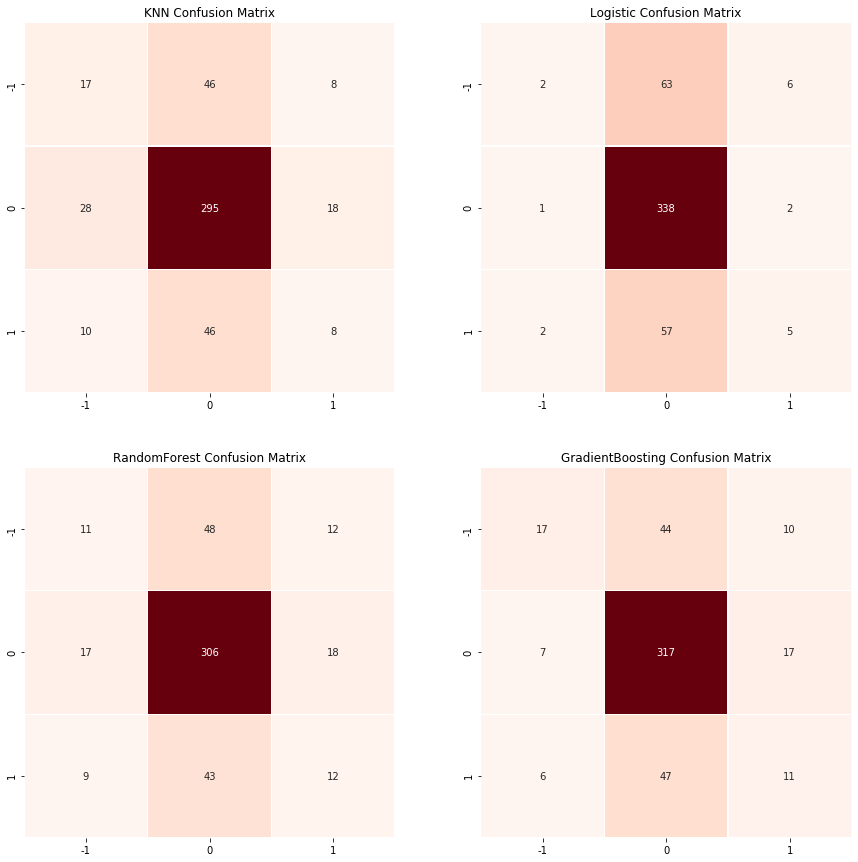

In [19]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(15, 15))

for (i, pipe) in enumerate(pipe_lines):
    predict = pipe.predict(X_test)
    cm = confusion_matrix(y_test.values.ravel(), predict, labels=[-1, 0, 1])
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(pipe_names[i] + ' Confusion Matrix')
    sns.heatmap(cm, square=True, linecolor='white', annot=True, ax=ax, cmap="Reds", cbar=False, fmt='d', linewidths=.5, xticklabels=[-1,0,1], yticklabels=[-1,0,1])

X_train shape: (964, 7)
X_test shape: (476, 7)
y_train shape: (964, 3)
y_test shape: (476, 3)


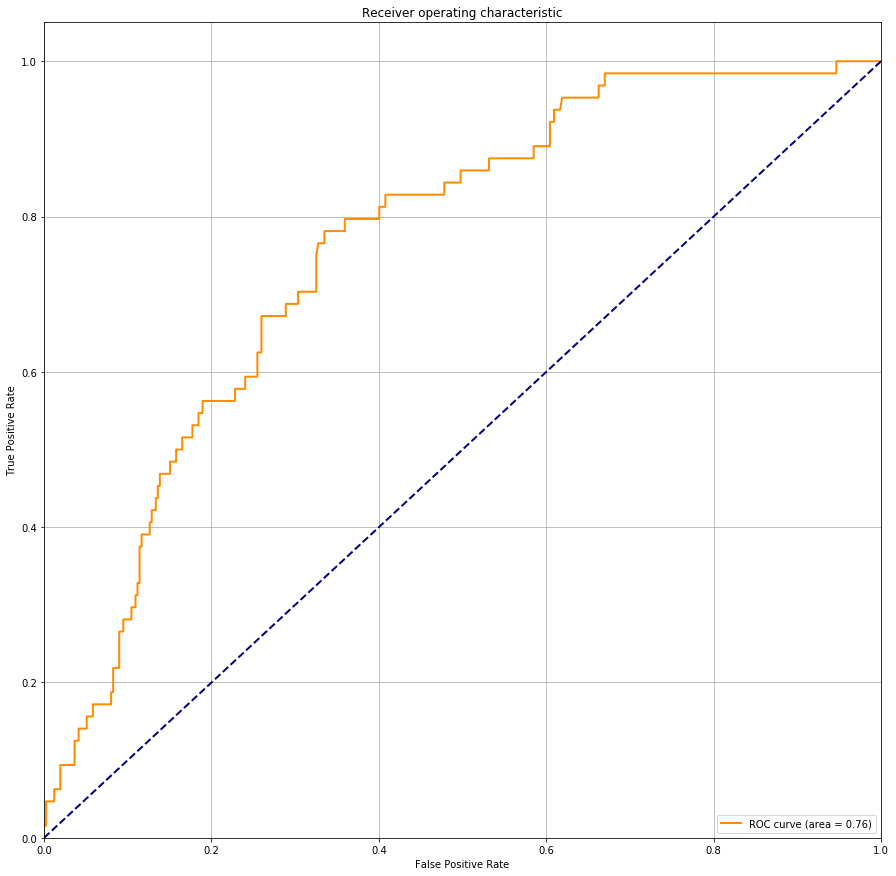

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y_binarized = label_binarize(y_, classes=[-1, 0, 1])
n_classes = y_binarized.shape[1]

X_train_binarized, X_test_binarized, y_train_binarized, y_test_binarized = train_test_split(X_, y_binarized, test_size=0.33, random_state=42)
print('X_train shape: {}'.format(X_train_binarized.shape))
print('X_test shape: {}'.format(X_test_binarized.shape))
print('y_train shape: {}'.format(y_train_binarized.shape))
print('y_test shape: {}'.format(y_test_binarized.shape))

# Learn to predict each class against the other
pipe_binarized = Pipeline([('scl', StandardScaler()), ('est', GradientBoostingClassifier(random_state=39))])
ovr_clf = OneVsRestClassifier(pipe_binarized) 
y_score_binarized = ovr_clf.fit(X_train_binarized, y_train_binarized).decision_function(X_test_binarized)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC curve
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
lw = 2
ax.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")
ax.grid()

In [75]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = cross_val_score(pipe_gb, X_, y_.values.ravel(), cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=39))
print('Cross validation with StratifiedKFold scores: {}'.format(cv))
print('Cross Validation with StratifiedKFold mean: {}'.format(cv.mean()))

Cross Validation with StratifiedKFold mean: 0.7401376469538963


In [87]:
# GridSearch
from sklearn.model_selection import GridSearchCV

n_features = len(df.columns)
param_grid = {
    'learning_rate': [0.01, 0.1, 1, 10],
    'n_estimators': [1, 10, 100, 200, 300],
    'max_depth': [1, 2, 3, 4, 5]
}
stratifiedcv = StratifiedKFold(n_splits=10, shuffle=True, random_state=39)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=42)

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=stratifiedcv)
grid_search.fit(X_train, y_train.values.ravel())
print('GridSearch Train Accuracy: {:.3f}'.format(accuracy_score(y_train.values.ravel(), grid_search.predict(X_train))))
print('GridSearch Test Accuracy: {:.3f}'.format(accuracy_score(y_test.values.ravel(), grid_search.predict(X_test))))
print('GridSearch Train F1 Score: {:.3f}'.format(f1_score(y_train.values.ravel(), grid_search.predict(X_train), average='micro')))
print('GridSearch Test F1 Score: {:.3f}'.format(f1_score(y_test.values.ravel(), grid_search.predict(X_test), average='micro')))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearch Train Accuracy: 0.769
GridSearch Test Accuracy: 0.712
GridSearch Train F1 Score: 0.769
GridSearch Test F1 Score: 0.712


In [90]:
print("Best params:\n{}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best params:
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}
Best cross-validation score: 0.74


In [103]:
results = pd.DataFrame(grid_search.cv_results_)
corr_params = results.drop(results.columns[[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20]], axis=1)
corr_params.head()

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score
0,0.01,1,1,0.728216
1,0.01,1,10,0.728216
2,0.01,1,100,0.728216
3,0.01,1,200,0.726141
4,0.01,1,300,0.724066


In [106]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv_gb = cross_val_score(grid_search, X_, y_.values.ravel(), cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=39))
print('Grid Search with nested cross validation scores: {}'.format(cv_gb))
print('Grid Search with nested cross validation mean: {}'.format(cv_gb.mean()))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Grid Search with nested cross validation scores: [0.71309771 0.72083333 0.73277662]
Grid Search with nested cross validation mean: 0.7222358881283725


In [105]:
from sklearn.datasets import load_iris
from sklearn.model_selection import ParameterGrid, StratifiedKFold

iris = load_iris()
param_grid = [{'kernel': ['rbf'],
               'C': [0.01, 1],
               'gamma': [0.1, 1]},
              {'kernel': ['linear'],
               'C': [0.01, 1]}]
print("List of parameter grids:\n{}".format(param_grid))

def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    for training_samples, test_samples in outer_cv.split(X, y):
        best_params = {}
        best_score = -np.inf
        for parameters in parameter_grid:
            cv_scores = []
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                inner_clf = Classifier(**parameters)
                inner_clf.fit(X[inner_train], y[inner_train])
                inner_score = inner_clf.score(X[inner_test], y[inner_test])
                cv_scores.append(inner_score)
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = parameters
        outer_clf = Classifier(**best_params)
        outer_clf.fit(X[training_samples], y[training_samples])
        outer_score = outer_clf.score(X[test_samples], y[test_samples])
        outer_scores.append(outer_score)
    return np.array(outer_scores)

scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print('Cross validation scores: {}'.format(scores))
print('Cross validation mean: {}'.format(scores.mean()))

List of parameter grids:
[{'kernel': ['rbf'], 'C': [0.01, 1], 'gamma': [0.1, 1]}, {'kernel': ['linear'], 'C': [0.01, 1]}]
Cross validation scores: [0.96666667 1.         0.9        0.96666667 1.        ]
Cross validation mean: 0.9666666666666668
